# LowProFool
## Adversarial examples generation on the german credit dataset

### Imports

In [131]:
# Misc
import random
import numpy as np
import pandas as pd
import tqdm
from tqdm import tqdm
from tqdm import tqdm_notebook
import math
import os
import time
import sys

In [132]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
# Sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [134]:
# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
# Keras 
import keras

In [135]:
# Helpers
from Adverse import lowProFool, deepfool
from Metrics import *

### Notebook config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


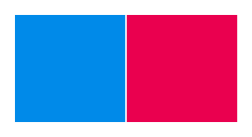

In [136]:
# Retina display
%config InlineBackend.figure_format ='retina'
pd.set_option('display.max_columns', 500)
tqdm.pandas()
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

ccolors = ["#008ae9", "#ea004f"]
sns.set_palette(ccolors)
sns.palplot(sns.color_palette())

### Constants

In [137]:
SEED = 0
DATASET = 'credit-g'

### Fetch data from openml

In [138]:
def get_df(dataset):
    assert(dataset == 'credit-g')
    
    dataset = fetch_openml(dataset)
    target = 'target'
    df = pd.DataFrame(data= np.c_[dataset['data'], dataset[target]], columns= dataset['feature_names'] + [target])  

    # Renaming target for training later
    df[target] = df[target].apply(lambda x: 0.0 if x == 'bad' or x == 0.0 else 1.0)

    # Subsetting features to keep only continuous, discrete and ordered categorical
    feature_names = ['checking_status', 'duration', 'credit_amount',
                 'savings_status','employment','installment_commitment',
                 'residence_since','age','existing_credits','num_dependents',
                 'own_telephone','foreign_worker']

    df = df[feature_names + [target]]

    # Casting to float for later purpose
    df = df.astype(float)
    return df, target, feature_names

### Preprocess data

In [139]:
def normalize(df, target, feature_names, bounds):
    df_return = df.copy()
    
    # Makes sure target does not need scaling
    targets = np.unique(df[target].values)
    assert(len(targets == 2) and 0. in targets and 1. in targets)
    
    scaler = MinMaxScaler()
    X = df_return[feature_names]
    scaler.fit(X)    
    df_return[feature_names] = scaler.transform(X)
    
    lower_bounds = scaler.transform([bounds[0]])
    upper_bounds = scaler.transform([bounds[1]])

    return scaler, df_return, (lower_bounds[0], upper_bounds[0])

# 逆正規化
def denormalize(scaler, normalized_df, feature_names):
    """
    正規化されたデータフレームを元のスケールに戻します

    Parameters:
    -----------
    scaler : MinMaxScaler
        normalize関数で使用したscalerインスタンス
    normalized_df : pandas.DataFrame
        正規化されたデータフレーム
    feature_names : list
        正規化された特徴量の名前のリスト

    Returns:
    --------
    pandas.DataFrame
        元のスケールに戻したデータフレーム
    """
    df_return = normalized_df.copy()

    # 特徴量のみを逆変換
    X_normalized = df_return[feature_names]
    df_return[feature_names] = scaler.inverse_transform(X_normalized)

    return df_return

def get_weights(df, target, show_heatmap=False):
    def heatmap(cor):
        plt.figure(figsize=(8,6))
        sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
        plt.show()

    cor = df.corr()
    cor_target = abs(cor[target])

    weights = cor_target[:-1] #removing target WARNING ASSUMES TARGET IS LAST
    weights = weights / np.linalg.norm(weights)

    if show_heatmap:
        heatmap(cor)
            
    return weights.values

def balance_df(df):
    len_df_0, len_df_1 = len(df[df[target] == 0.]), len(df[df[target] == 1.])
    df_0 = df[df[target] == 0.].sample(min(len_df_0, len_df_1), random_state=SEED)
    df_1 = df[df[target] == 1.].sample(min(len_df_0, len_df_1), random_state=SEED)
    df = pd.concat((df_0, df_1))
    return df

def get_bounds():
    low_bounds = df_orig.min().values
    up_bounds = df_orig.max().values
    
    #removing target WARNING ASSUMES TARGET IS LAST
    low_bounds = low_bounds[:-1]
    up_bounds = up_bounds[:-1]
    
    return [low_bounds, up_bounds]

def split_train_test_valid():
    # Train test splits
    df_train, df_test = train_test_split(df, test_size=300, shuffle=True, random_state=SEED)
    df_test, df_valid = train_test_split(df_test, test_size=50, shuffle=True, random_state=SEED)
    
    return df_train, df_test, df_valid

### Training neural net

In [140]:
def get_model(conf, load=False):
    assert(conf['Dataset'] == 'credit-g')
    
    class GermanNet(nn.Module):
        def __init__(self, D_in, H, D_out):
            super(GermanNet, self).__init__()
            self.linear1 = torch.nn.Linear(D_in, H)
            self.linear2 = torch.nn.Linear(H, H)
            self.linear3 = torch.nn.Linear(H, D_out)
            self.relu = torch.nn.ReLU()
            self.softmax = torch.nn.Softmax(dim=-1)

        def forward(self, x):
            h1 = self.relu(self.linear1(x))
            h2 = self.relu(self.linear2(h1))
            h3 = self.relu(self.linear2(h2))
            h4 = self.relu(self.linear2(h3))
            h5 = self.relu(self.linear2(h4))
            h6 = self.relu(self.linear2(h5))
            a3 = self.linear3(h6)
            y = self.softmax(a3)
            return y

    def train(model, criterion, optimizer, X, y, N, n_classes):
        model.train()

        current_loss = 0
        current_correct = 0


        # Training in batches
        for ind in range(0, X.size(0), N):
            indices = range(ind, min(ind + N, X.size(0)) - 1) 
            inputs, labels = X[indices], y[indices]
            inputs = Variable(inputs, requires_grad=True)


            optimizer.zero_grad()

            output = model(inputs)
            _, indices = torch.max(output, 1) # argmax of output [[0.61, 0.12]] -> [0]
            # [[0, 1, 1, 0, 1, 0, 0]] -> [[1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0]]
            preds = torch.tensor(keras.utils.to_categorical(indices, num_classes=n_classes))

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            current_correct += (preds.int() == labels.int()).sum() /n_classes


        current_loss = current_loss / X.size(0)
        current_correct = current_correct.double() / X.size(0)    

        return preds, current_loss, current_correct.item()
    
    df = conf['TrainData']
    target = conf['Target']
    feature_names = conf['FeatureNames']
                        
    n_classes = len(np.unique(df[target]))
    X_train = torch.FloatTensor(df[feature_names].values)
    y_train = keras.utils.to_categorical(df[target], n_classes)
    y_train = torch.FloatTensor(y_train)

    D_in = X_train.size(1)
    D_out = y_train.size(1)

    epochs = 400
    batch_size = 100
    H = 100
    net = GermanNet(D_in, H, D_out)

    lr = 1e-4    
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        preds, epoch_loss, epoch_acc = train(net, criterion, optimizer, X_train, y_train, batch_size, n_classes)     
        if (epoch % 50 == 0):
            print("> epoch {:.0f}\tLoss {:.5f}\tAcc {:.5f}".format(epoch, epoch_loss, epoch_acc))

    model_path = 'model_data/model.pth'
    # ディレクトリが存在しない場合は作成
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    torch.save(net.state_dict(), model_path)
    net.eval()
    
    return net

### Generate adversarial examples

In [141]:
def gen_adv(config, method):
    df_test = config['TestData']
    extra_cols = ['orig_pred', 'adv_pred', 'iters']    
    model = config['Model']
    weights = config['Weights']
    bounds = config['Bounds']
    maxiters = config['MaxIters']
    alpha = config['Alpha']
    lambda_ = config['Lambda']
    
    results = np.zeros((len(df_test), len(feature_names) + len(extra_cols)))    
            
    i = -1
    for _, row in tqdm_notebook(df_test.iterrows(), total=df_test.shape[0], desc="{}".format(method)):
        i += 1
        print(df_test.iloc[i].name)
        x_tensor = torch.FloatTensor(row[config['FeatureNames']])   
        
        if method == 'LowProFool':
            orig_pred, adv_pred, x_adv, loop_i = lowProFool(x_tensor, model, weights, bounds,
                                                             maxiters, alpha, lambda_)
        elif method == 'Deepfool':
            orig_pred, adv_pred, x_adv, loop_i = deepfool(x_tensor, model, maxiters, alpha,
                                                          bounds, weights=[])
        else:
            raise Exception("Invalid method", method)
        results[i] = np.concatenate((x_adv, [orig_pred, adv_pred, loop_i]), axis=0)
        
    return pd.DataFrame(results, index=df_test.index, columns = feature_names + extra_cols)

# 実行開始

In [142]:
# Load initial dataset
df_orig, target, feature_names = get_df(DATASET)

# Balance dataset classes
df = balance_df(df_orig)

# Compute the bounds for clipping
bounds = get_bounds()

# Normalize the data
scaler, df, bounds = normalize(df, target, feature_names, bounds)

# Compute the weihts modelizing the expert's knowledge
weights = get_weights(df, target)

# Split df into train/test/valid
df_train, df_test, df_valid = split_train_test_valid()

# Build experimenation config
config = {'Dataset'     : 'credit-g',
         'MaxIters'     : 20000,
         'Alpha'        : 0.001,
         'Lambda'       : 8.5,
         'TrainData'    : df_train,
         'TestData'     : df_test,
         'ValidData'    : df_valid,
         'Scaler'       : scaler,
         'FeatureNames' : feature_names,
         'Target'       : target,
         'Weights'      : weights,
         'Bounds'       : bounds}

# Train neural network
model = get_model(config)
config['Model'] = model

# Compute accuracy on test set
y_true = df_test[target]
x_test = torch.FloatTensor(df_test[feature_names].values)
y_pred = model(x_test)
y_pred = np.argmax(y_pred.detach().numpy(), axis=1)
print("Accuracy score on test data", accuracy_score(y_true, y_pred))
    
# Sub sample
config['TestData'] = config['TestData'].sample(n=10, random_state = SEED)

# Generate adversarial examples
df_adv_lpf = gen_adv(config, 'LowProFool')
df_adv_df = gen_adv(config, 'Deepfool')
config['AdvData'] = {'LowProFool' : df_adv_lpf, 'Deepfool' : df_adv_df}

# Compute metrics
list_metrics = {'SuccessRate' : True,
                'iter_means': False,
                'iter_std': False,
                'normdelta_median': False,
                'normdelta_mean': True,
                'n_std': True,
                'weighted_median': False,
                'weighted_mean': True,
                'w_std': True,
                'mean_dists_at_org': False,
                'median_dists_at_org': False,
                'mean_dists_at_tgt': False,
                'mean_dists_at_org_weighted': True,
                'mdow_std': True,
                'median_dists_at_org_weighted': False,
                'mean_dists_at_tgt_weighted': True,
                'mdtw_std': True,
                'prop_same_class_arg_org': False,
                'prop_same_class_arg_adv': False}

all_metrics = get_metrics(config, list_metrics)
all_metrics = pd.DataFrame(all_metrics, columns=['Method'] + [k for k, v in list_metrics.items() if v])
all_metrics

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/datasets/openml.py:305: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


> epoch 0	Loss 0.00698	Acc 0.47333
> epoch 50	Loss 0.00669	Acc 0.71333
> epoch 100	Loss 0.00508	Acc 0.73000
> epoch 150	Loss 0.00481	Acc 0.75000
> epoch 200	Loss 0.00453	Acc 0.76000
> epoch 250	Loss 0.00412	Acc 0.81000
> epoch 300	Loss 0.00361	Acc 0.83667
> epoch 350	Loss 0.00310	Acc 0.85667
Accuracy score on test data 0.676


685
output_prod [0.9008676  0.09913234]
727
output_prod [0.21561287 0.7843872 ]
30
output_prod [0.793486 0.206514]
376
output_prod [0.1375668 0.8624332]
66
output_prod [0.81592405 0.18407594]
965
output_prod [0.96038836 0.03961167]
963
output_prod [0.8725951  0.12740491]
61
output_prod [0.715682 0.284318]
282
output_prod [0.95381314 0.04618694]
268
output_prod [0.04092333 0.95907664]


685
727
30
376
66
965
963
61
282
268


,Method,SuccessRate,normdelta_mean,n_std,weighted_mean,w_std,mean_dists_at_org_weighted,mdow_std,mean_dists_at_tgt_weighted,mdtw_std
0,LowProFool,1.0,0.320324,0.317873,0.043336,0.039835,0.214625,0.085894,0.209034,0.084099
1,Deepfool,1.0,0.201288,0.144257,0.076153,0.064458,0.214625,0.085894,0.204265,0.080647


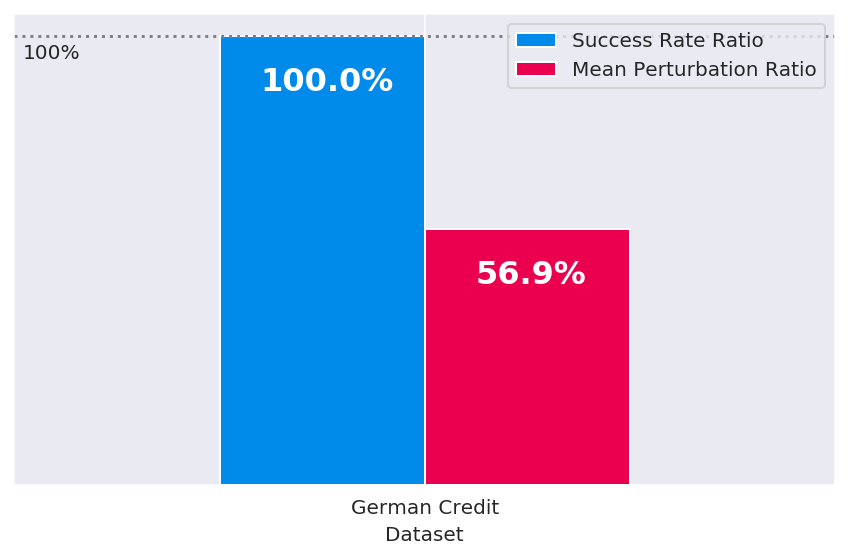

In [143]:
plot_ratios = []

m_lpf = all_metrics[all_metrics.Method == 'LowProFool']
m_df = all_metrics[all_metrics.Method =='Deepfool']

sr = m_lpf.SuccessRate.values / m_df.SuccessRate.values 
wm =  m_lpf.weighted_mean.values / m_df.weighted_mean.values 

plot_ratios.append([100*sr[0], 100*wm[0]])
plot_ratios = pd.DataFrame(plot_ratios, columns=['Success Rate Ratio', 'Mean Perturbation Ratio'])
plot_ratios['Dataset'] = 'German Credit'

f = plt.figure()
ax = plt.axes()
plot_ratios.plot(x='Dataset', kind='bar', legend=True, ax=ax)

for i, v in enumerate(plot_ratios['Success Rate Ratio'].values):
    ax.text(i - 0.2, v - 12 , str(v.round(1)) + '%', fontsize=16, color='white', weight='bold')
for i, v in enumerate(plot_ratios['Mean Perturbation Ratio'].values):
    ax.text(i + 0.062, v - 12, str(v.round(1)) + '%', fontsize=16, color='white', weight='bold')

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')
ax.axhline(100, ls=':', c='grey')
ax.text(-0.49, 100 - 5, '100%')


ax.set_yticks([])
plt.tight_layout()
plt.show()

### CSV出力

In [144]:
# 逆正規化
df_adv_lpf = denormalize(scaler, df_adv_lpf, feature_names=feature_names)
# lowprofool
df_adv_lpf.to_csv('data/lowprofool_propose1.csv')

# 逆正規化
df_adv_df = denormalize(scaler, df_adv_df, feature_names=feature_names)
# deepfool
df_adv_df.to_csv('data/deepfool_propose1.csv')

In [145]:
df_orig = pd.read_csv('data/df_orig.csv')
df_adv_lpf = pd.read_csv('data/lowprofool_propose1.csv')
df_adv_df = pd.read_csv('data/deepfool_propose1.csv')

In [146]:
arrs = [685, 727, 30, 376, 66, 965, 963, 61, 282, 268]

for i in arrs:
    orig_row = df_orig[df_orig['Unnamed: 0'] == i].copy()
    adv_lpf_row = df_adv_lpf[df_adv_lpf['Unnamed: 0'] == i].copy()
    adv_df_row = df_adv_df[df_adv_df['Unnamed: 0'] == i].copy()
    
    # Rename columns to match the original format
    orig_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in orig_row.columns]
    adv_lpf_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in adv_lpf_row.columns]
    adv_df_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in adv_df_row.columns]
    
    # Combine rows into a single DataFrame
    combined_df = pd.concat([orig_row, adv_lpf_row, adv_df_row], keys=['orig', 'adv_lpf', 'adv_df']).reset_index(level=0).rename(columns={'level_0': 'type'})
    
    # Save the DataFrame as df_output_{id}
    globals()[f'df_output_{i}'] = combined_df

# Example to access one of the generated DataFrames
df_output_685

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
685,orig,NaN,34.000000,3.000000,6527.000000,60.000000,2.000000,1.0,0.0,685,4.0,NaN,2.0,NaN,1.000000,4.0,4.000000,1.0
0,adv_lpf,0.0,35.369524,2.999008,5798.563315,59.939824,1.794402,1.0,0.0,685,4.0,50.0,2.0,1.0,0.886632,4.0,3.891405,NaN
0,adv_df,0.0,35.950148,2.991625,5396.662780,59.637458,1.752731,1.0,0.0,685,4.0,214.0,2.0,1.0,0.921984,4.0,3.862095,NaN


In [147]:
df_output_727

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
727,orig,NaN,25.000000,0.000000,1882.000000,18.000000,2.000000,2.000000,0.000000,727,4.000000,NaN,1.0,NaN,0.000000,4.0,0.0,0.0
1,adv_lpf,1.0,26.225218,0.173080,655.261333,12.003761,2.108032,1.808745,0.065637,727,3.983764,15.0,1.0,0.0,0.061552,4.0,0.0,NaN
1,adv_df,1.0,25.977536,0.286399,853.260747,12.442201,2.085170,1.855178,0.047187,727,3.981576,164.0,1.0,0.0,0.043153,4.0,0.0,NaN


In [148]:
df_output_30

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
30,orig,NaN,36.000000,1.000000,1913.000000,18.000000,1.000000,1.000000,0.0,30,3.000000,NaN,1.0,NaN,1.0,3.000000,3.000000,1.0
2,adv_lpf,0.0,36.411328,0.979135,2875.817523,19.704454,0.862333,1.415493,0.0,30,2.967586,52.0,1.0,1.0,1.0,2.736630,2.925984,NaN
2,adv_df,0.0,36.320312,0.845203,3320.488479,21.771063,0.843581,1.273614,0.0,30,2.962933,165.0,1.0,1.0,1.0,2.855428,2.923555,NaN


### int型に変換

In [149]:
arrs = [685, 727, 30, 376, 66, 965, 963, 61, 282, 268]

for i in arrs:
    orig_row = df_orig[df_orig['Unnamed: 0'] == i].copy()
    adv_lpf_row = df_adv_lpf[df_adv_lpf['Unnamed: 0'] == i].copy()
    adv_df_row = df_adv_df[df_adv_df['Unnamed: 0'] == i].copy()
    
    # Rename columns to match the original format
    orig_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in orig_row.columns]
    adv_lpf_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in adv_lpf_row.columns]
    adv_df_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in adv_df_row.columns]
    
    # Combine rows into a single DataFrame
    combined_df = pd.concat([orig_row, adv_lpf_row, adv_df_row], keys=['orig', 'adv_lpf', 'adv_df']).reset_index(level=0).rename(columns={'level_0': 'type'})
    
    # Round and convert to int
    combined_df.loc[:, combined_df.columns != 'type'] = combined_df.loc[:, combined_df.columns != 'type'].fillna(0).round().astype(int)
    
    # Save the DataFrame as df_output_{id}
    globals()[f'df_output_i_{i}'] = combined_df

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [150]:
df_output_i_685

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
685,orig,0,34,3,6527,60,2,1,0,685,4,0,2,0,1,4,4,1
0,adv_lpf,0,35,3,5799,60,2,1,0,685,4,50,2,1,1,4,4,0
0,adv_df,0,36,3,5397,60,2,1,0,685,4,214,2,1,1,4,4,0


In [151]:
df_output_i_727

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
727,orig,0,25,0,1882,18,2,2,0,727,4,0,1,0,0,4,0,0
1,adv_lpf,1,26,0,655,12,2,2,0,727,4,15,1,0,0,4,0,0
1,adv_df,1,26,0,853,12,2,2,0,727,4,164,1,0,0,4,0,0


In [152]:
df_output_i_30

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
30,orig,0,36,1,1913,18,1,1,0,30,3,0,1,0,1,3,3,1
2,adv_lpf,0,36,1,2876,20,1,1,0,30,3,52,1,1,1,3,3,0
2,adv_df,0,36,1,3320,22,1,1,0,30,3,165,1,1,1,3,3,0


In [180]:
none, target, feature_names = get_df(DATASET)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/datasets/openml.py:305: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


### 確率の出力

In [181]:
df_orig_int = df_orig.copy()
scaler, df_orig_int, bounds = normalize(df_orig_int, target, feature_names, bounds)
df_orig_int_test = torch.FloatTensor(df_orig_int[feature_names].values)
y_pred_orig = model(df_orig_int_test)
print(y_pred_orig)

tensor([[0.1833, 0.8167],
        [0.9819, 0.0181],
        [0.7973, 0.2027],
        ...,
        [0.0038, 0.9962],
        [0.9279, 0.0721],
        [0.9678, 0.0322]], grad_fn=<SoftmaxBackward>)


In [182]:
df_orig_filltered = df_orig[df_orig['Unnamed: 0'].isin(arrs)].copy()
scaler, df_orig_filltered, bounds = normalize(df_orig_filltered, target, feature_names, bounds)
df_orig_test_filltered = torch.FloatTensor(df_orig_filltered[feature_names].values)
y_pred_orig_filltered = model(df_orig_test_filltered)
print(y_pred_orig_filltered)

tensor([[1.6658e-01, 8.3342e-01],
        [2.6305e-03, 9.9737e-01],
        [3.2000e-01, 6.8000e-01],
        [9.9993e-01, 6.5231e-05],
        [2.0047e-01, 7.9953e-01],
        [8.1273e-01, 1.8727e-01],
        [4.0366e-01, 5.9634e-01],
        [9.9042e-01, 9.5774e-03],
        [2.4047e-02, 9.7595e-01],
        [5.9564e-01, 4.0436e-01]], grad_fn=<SoftmaxBackward>)


In [183]:
df_adv_lpf = df_adv_lpf.copy()
scaler, df_adv_lpf, bounds = normalize(df_adv_lpf, 'orig_pred', feature_names, bounds)
df_adv_lpf_test = torch.FloatTensor(df_adv_lpf[feature_names].values)
y_pred_lpf = model(df_adv_lpf_test)
print(y_pred_lpf)

tensor([[0.5286, 0.4714],
        [0.5185, 0.4815],
        [0.7200, 0.2800],
        [0.6466, 0.3534],
        [0.5654, 0.4346],
        [0.5614, 0.4386],
        [0.9779, 0.0221],
        [0.8676, 0.1324],
        [0.9850, 0.0150],
        [0.6938, 0.3062]], grad_fn=<SoftmaxBackward>)


In [184]:
df_adv_df = df_adv_df.copy()
scaler, df_adv_df, bounds = normalize(df_adv_df, 'orig_pred', feature_names, bounds)
df_adv_df_test = torch.FloatTensor(df_adv_df[feature_names].values)
y_pred_df = model(df_adv_df_test)
print(y_pred_df)

tensor([[0.5533, 0.4467],
        [0.9153, 0.0847],
        [0.8981, 0.1019],
        [0.8789, 0.1211],
        [0.7544, 0.2456],
        [0.7101, 0.2899],
        [0.9987, 0.0013],
        [0.9718, 0.0282],
        [0.8590, 0.1410],
        [0.9989, 0.0011]], grad_fn=<SoftmaxBackward>)


In [189]:
# Filter the DataFrame
df_orig_filltered = df_orig[df_orig['Unnamed: 0'].isin(arrs)].copy()

# Round and convert to int
df_orig_filltered_int = df_orig_filltered.round().astype(int)

# Normalize the data
scaler, df_orig_int_filltered, bounds = normalize(df_orig_filltered_int, target, feature_names, bounds)
df_orig_int_test_filltered = torch.FloatTensor(df_orig_int_filltered[feature_names].values)
y_pred_orig_filltered = model(df_orig_int_test_filltered)
print(y_pred_orig_filltered)

tensor([[1.6658e-01, 8.3342e-01],
        [2.6305e-03, 9.9737e-01],
        [3.2000e-01, 6.8000e-01],
        [9.9993e-01, 6.5231e-05],
        [2.0047e-01, 7.9953e-01],
        [8.1273e-01, 1.8727e-01],
        [4.0366e-01, 5.9634e-01],
        [9.9042e-01, 9.5774e-03],
        [2.4047e-02, 9.7595e-01],
        [5.9564e-01, 4.0436e-01]], grad_fn=<SoftmaxBackward>)


In [194]:
df_adv_lpf = df_adv_lpf[df_adv_lpf['Unnamed: 0'].isin(arrs)].copy()

# Round and convert to int
df_adv_lpf_int = df_adv_lpf.round().astype(int)

scaler, df_adv_lpf_int, bounds = normalize(df_adv_lpf_int, 'orig_pred', feature_names, bounds)


df_adv_lpf_int_test = torch.FloatTensor(df_adv_lpf_int[feature_names].values)
y_pred_lpf = model(df_adv_lpf_int_test)
print(y_pred_lpf)

tensor([[0.9590, 0.0410],
        [0.4803, 0.5197],
        [0.2797, 0.7203],
        [0.6901, 0.3099],
        [0.1875, 0.8125],
        [0.9917, 0.0083],
        [0.9929, 0.0071],
        [0.9376, 0.0624],
        [0.9527, 0.0473],
        [0.9734, 0.0266]], grad_fn=<SoftmaxBackward>)


In [195]:
df_adv_df = df_adv_df[df_adv_df['Unnamed: 0'].isin(arrs)].copy()

# Round and convert to int
df_adv_df_int = df_adv_df.round().astype(int)

scaler, df_adv_df_int, bounds = normalize(df_adv_df_int, 'orig_pred', feature_names, bounds)

df_adv_df_test = torch.FloatTensor(df_adv_df_int[feature_names].values)
y_pred_df = model(df_adv_df_test)
print(y_pred_df)

tensor([[9.5898e-01, 4.1023e-02],
        [4.8032e-01, 5.1968e-01],
        [9.5730e-01, 4.2699e-02],
        [6.9012e-01, 3.0988e-01],
        [1.8748e-01, 8.1252e-01],
        [5.4182e-01, 4.5818e-01],
        [9.9288e-01, 7.1198e-03],
        [7.8716e-01, 2.1284e-01],
        [9.8816e-01, 1.1835e-02],
        [9.9982e-01, 1.8491e-04]], grad_fn=<SoftmaxBackward>)
